Calculate input proportion (i.e. inprop, normalised connectivity) for optic lobe neurons on the *right* hemisphere of FAFB on a signle neuron level. Cell super classes of 'optic', 'visual_projection', and 'visual_centrifugal' are kept. In addition, `super_class == 'sensory'` are also kept if `cell_class == 'visual'`.  

In terms of connections, every connection between the cells above is kept. In addition, to account for contralateral input, the following connections are kept: 
- if it's upstream of the right side 'optic' or 'sensory', and 
- if the neuropil of the connection is on the right. 

Meta information for all the neurons involved above are kept. Input proportion are calculated using the total number of post-synapses each neuron has, regardless of where the connections are (central brain or optic lobe). 

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
chosen_side = "right"
side_first_letter = "R"

# reading data

In [3]:
info = pd.read_csv(
    "https://raw.githubusercontent.com/flyconnectome/flywire_annotations/main/supplemental_files/Supplemental_file1_neuron_annotations.tsv",
    delimiter="\t",
)

info.columns

C:\Users\44745\AppData\Local\Temp\ipykernel_43896\611402832.py:1: DtypeWarning: Columns (14,15,16,17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  info = pd.read_csv(


Index(['supervoxel_id', 'root_id', 'pos_x', 'pos_y', 'pos_z', 'soma_x',
       'soma_y', 'soma_z', 'nucleus_id', 'flow', 'super_class', 'cell_class',
       'cell_sub_class', 'cell_type', 'hemibrain_type', 'ito_lee_hemilineage',
       'hartenstein_hemilineage', 'morphology_group', 'top_nt', 'top_nt_conf',
       'known_nt', 'known_nt_source', 'side', 'nerve', 'vfb_id', 'fbbt_id',
       'status'],
      dtype='object')

In [4]:
# read columns, downloaded from here:
# https://codex.flywire.ai/api/download

vis_cols = pd.read_csv(
    "C:/Users/44745/Downloads/column_assignment.csv.gz", compression="gzip"
)
vis_cols["coords"] = vis_cols["x"].astype(str) + "," + vis_cols["y"].astype(str)
root_to_coords = dict(zip(vis_cols["root_id"], vis_cols["coords"]))
vis_cols

,root_id,hemisphere,type,column_id,x,y,p,q,coords
0,720575940603042272,right,Mi1,1,-6,13,12,1,"-6,13"
1,720575940603200428,right,Mi1,2,-8,2,9,-7,"-8,2"
2,720575940603327916,right,Mi1,3,6,-12,-12,0,"6,-12"
3,720575940603935334,right,Mi1,4,-5,-21,-6,-15,"-5,-21"
4,720575940633953965,right,Mi1,5,-1,16,9,7,"-1,16"
...,...,...,...,...,...,...,...,...,...
22679,720575940614768179,right,Tm9,791,-1,-28,-13,-15,"-1,-28"
22680,720575940617322101,right,Tm9,792,8,2,-7,9,"8,2"
22681,720575940629639674,right,Tm9,793,8,-6,-11,5,"8,-6"
22682,720575940634654945,right,Tm9,795,6,-21,-17,-4,"6,-21"


In [5]:
vis_cols[["x", "y"]].agg([min, max])

C:\Users\44745\AppData\Local\Temp\ipykernel_43896\3417811160.py:1: FutureWarning: The provided callable <built-in function min> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  vis_cols[["x", "y"]].agg([min, max])
C:\Users\44745\AppData\Local\Temp\ipykernel_43896\3417811160.py:1: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  vis_cols[["x", "y"]].agg([min, max])


,x,y
min,-9,-29
max,8,30


Coordinates seem a bit different from [Nern et al 2024](https://www.biorxiv.org/content/10.1101/2024.04.16.589741v2), where:  
	x	y  
min	-16	7  
max	19	72  

In [6]:
vis_cols["type"].unique()

array(['Mi1', 'C2', 'C3', 'L1', 'L2', 'L3', 'L4', 'L5', 'Mi4', 'Mi9',
       'R7', 'R8', 'T1', 'T2', 'T2a', 'T3', 'T4a', 'T4b', 'T4c', 'T4d',
       'T5a', 'T5b', 'T5c', 'T5d', 'Tm1', 'Tm2', 'Tm20', 'Tm21', 'Tm3',
       'Tm4', 'Tm9'], dtype=object)

In [7]:
vis_cols["type"].value_counts()

type
Mi1     796
L2      791
L1      789
L5      777
T4c     777
Tm1     773
C3      767
Tm2     766
T2a     765
Mi9     765
Mi4     764
Tm9     754
T4d     748
Tm3     744
T4b     744
T5b     743
C2      743
Tm20    739
T5c     737
T1      734
T5a     733
L3      730
T4a     729
T3      728
T2      720
Tm4     719
L4      713
T5d     708
Tm21    619
R8      597
R7      472
Name: count, dtype: int64

In [8]:
info.super_class.value_counts(dropna=False)

super_class
optic                 77536
central               32388
sensory               16903
visual_projection      8053
ascending              2362
descending             1303
visual_centrifugal      524
motor                   106
endocrine                80
Name: count, dtype: int64

In [9]:
optic = info[
    info.super_class.isin(
        ["visual_projection", "visual_centrifugal", "optic", "sensory"]
    )
]


optic.columns

Index(['supervoxel_id', 'root_id', 'pos_x', 'pos_y', 'pos_z', 'soma_x',
       'soma_y', 'soma_z', 'nucleus_id', 'flow', 'super_class', 'cell_class',
       'cell_sub_class', 'cell_type', 'hemibrain_type', 'ito_lee_hemilineage',
       'hartenstein_hemilineage', 'morphology_group', 'top_nt', 'top_nt_conf',
       'known_nt', 'known_nt_source', 'side', 'nerve', 'vfb_id', 'fbbt_id',
       'status'],
      dtype='object')

In [10]:
optic[optic.super_class == "sensory"].cell_class.value_counts(dropna=False)

cell_class
visual             11391
mechanosensory      2648
olfactory           2281
gustatory            343
unknown_sensory      135
hygrosensory          74
thermosensory         29
NaN                    2
Name: count, dtype: int64

In [11]:
# to get the relevant neurons
# it is not sensory
optic = optic[
    (optic.super_class != "sensory")
    |
    # or visual sensory
    ((optic.super_class == "sensory") & (optic.cell_class == "visual"))
]

In [12]:
# where are the cell types?
optic[["cell_type", "hemibrain_type"]].isna().value_counts()

cell_type  hemibrain_type
False      True              84063
True       True               6126
           False              4039
False      False              3276
Name: count, dtype: int64

In [13]:
# around 3k with both cell_type and hemibrain_type - do they correspond to each other?
optic[~optic.cell_type.isna() & ~optic.hemibrain_type.isna()][
    ["cell_type", "hemibrain_type"]
].value_counts()

cell_type  hemibrain_type             
MeTu4      MC61,MC64                      278
MeTu3      MC61,MC64                      274
MeTu1      MC61,MC64                      244
LLPC2      LLPC2a,LLPC2b,LLPC2c,LLPC2d    235
LC10a      LC10                           234
                                         ... 
MeLp1      5813068976                       2
LCe01b     LC25                             1
           LC25,LC26                        1
LCe01a     LC25,LC26                        1
LCe02      LC25                             1
Name: count, Length: 209, dtype: int64

In [14]:
# since hemibrain is truncated, let's prioritize cell_type
optic.loc[:, ["combined_type"]] = optic.cell_type
# fill the leftover nas with hemibrain_type
optic.combined_type.fillna(optic.hemibrain_type, inplace=True)
# then fill the rest with root ids
optic.combined_type.fillna(optic.root_id.astype(str), inplace=True)

In [15]:
optic[optic.combined_type.str.startswith("R")][
    ["combined_type", "side", "super_class"]
].value_counts()

combined_type  side   super_class
R1-6           left   sensory        4423
               right  sensory        4029
R7             left   sensory         672
               right  sensory         670
R8             left   sensory         670
               right  sensory         654
R7             right  optic             1
Name: count, dtype: int64

In [16]:
# make dictionaries to map between columns
typedict = dict(zip(optic.root_id, optic.combined_type))
sidedict = dict(zip(optic.root_id, optic.side))
type_super_class_dict = dict(zip(optic.combined_type, optic.super_class))
type_class_dict = dict(zip(optic.combined_type, optic.cell_class))
type_sub_class_dict = dict(zip(optic.combined_type, optic.cell_sub_class))

## read connectivity
Courtesy of Dr Sven Dorkenwald: https://zenodo.org/records/10676866

In [17]:
# this can take a minute or two
from io import BytesIO
import requests

url = "https://zenodo.org/records/10676866/files/proofread_connections_783.feather"

# Download the file
response = requests.get(url)

# Use the file content directly in Python
file_content = response.content

conn_full = pd.read_feather(BytesIO(file_content))
conn_full

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,2.724177e-01,4.812546e-02,4.724386e-04,0.000951
1,720575940623828999,720575940612348950,SLP_R,4,0.386517,0.024020,5.805122e-01,8.166312e-04,8.567505e-04,0.007278
2,720575940624078484,720575940616950161,SMP_R,2,0.001719,0.979256,1.810526e-03,1.633383e-05,5.870429e-03,0.011328
3,720575940629583345,720575940620324735,SMP_L,2,0.011815,0.031954,4.729873e-01,9.134340e-03,8.697341e-02,0.387136
4,720575940605876866,720575940606514878,LAL_R,15,0.994271,0.005063,5.223293e-04,3.998458e-07,1.034742e-04,0.000040
...,...,...,...,...,...,...,...,...,...,...
16847992,720575940615769750,720575940622822680,AVLP_L,1,0.004619,0.896132,3.206258e-02,1.844075e-03,2.894549e-02,0.036396
16847993,720575940624016823,720575940622760993,ME_R,4,0.080482,0.536168,2.336121e-02,3.442164e-01,2.744474e-04,0.015498
16847994,720575940637397309,720575940633255123,SLP_R,2,0.987325,0.008161,4.205040e-03,8.760364e-06,2.006123e-05,0.000281
16847995,720575940636432014,720575940617470681,ME_R,1,0.026646,0.031076,9.088086e-01,4.470230e-03,1.418527e-02,0.014815


# NT

In [18]:
optic.top_nt.value_counts(dropna=False)

top_nt
acetylcholine    64852
glutamate        17269
gaba             13952
serotonin          747
NaN                456
octopamine         146
dopamine            82
Name: count, dtype: int64

In [19]:
optic.known_nt.unique()

array([nan, 'acetylcholine', 'glutamate, Dh44, allatostatin-c',
       'octopamine', 'glycine, pdf', 'ion-transport peptide', 'glycine',
       'glycine, pdf, sNPF', 'gaba', 'serotonin', 'dopamine', 'glutamate',
       'acetylcholine, allatostatin-a', 'gaba, nitric oxide',
       'acetylcholine, nitric oxide', 'glutamate, gaba',
       'gaba, nitric oxide, allatostatin-c',
       'acetylcholine, nitric oxide, dopamine', 'histamine',
       'acetylcholine, allatostatin-c'], dtype=object)

In [20]:
# known_nt takes priority
optic["known_nt_simplified"] = optic.known_nt
# pattern matching: only keep if value contains 'glutamate', 'gaba', or 'acetylcholine'
optic.known_nt_simplified = optic.known_nt_simplified.str.extract(
    "(glutamate|gaba|acetylcholine)", expand=False
)
# note that if a value has multiple matches, only the first one is kept
# e.g. 'glutamate, gaba' will be simplified to 'glutamate'
optic.known_nt_simplified.value_counts(dropna=False)

# then use this column to replace values in top_nt column
optic.top_nt = optic.known_nt_simplified.fillna(optic.top_nt)

(array([6.635e+03, 5.900e+01, 0.000e+00, 1.300e+01, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 5.000e+00]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

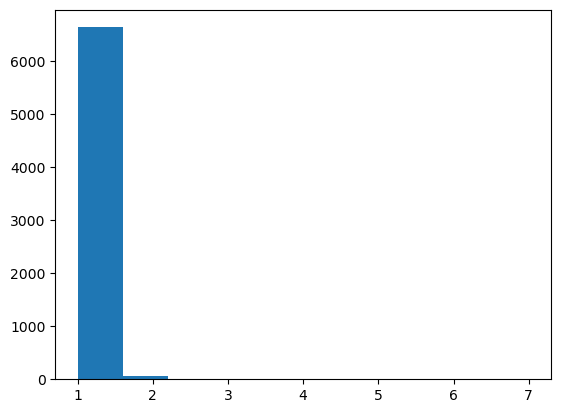

In [21]:
# first check consistency of NT within each type
optic["top_nt"] = optic["top_nt"].fillna("unknown")
nt_count_per_type = optic.groupby("combined_type")["top_nt"].nunique()
plt.hist(nt_count_per_type)

In [22]:
# For those with different NT for each neuron, get the majority NT for each type
nt_conflict_types = nt_count_per_type[nt_count_per_type > 1].index

# Getting counts of top_nt for each combined_type
nt_conflict_type_counts = (
    optic[optic.combined_type.isin(nt_conflict_types)]
    .groupby(["combined_type", "top_nt"])
    .size()
)

# Convert the series to a DataFrame and reset index
nt_conflict_type_counts = nt_conflict_type_counts.reset_index(name="counts")

# Sort by combined_type and counts in descending order
nt_conflict_type_counts.sort_values(
    by=["combined_type", "counts"], ascending=[True, False], inplace=True
)

# Initialize dictionary with existing type-nt matching
type_nt = dict(zip(optic.combined_type, optic.top_nt))
# Initialize a list to keep track of types with equal top_nt counts
types_with_equal_top_nt_counts = []


# Custom function to handle ties, random selection, and record keeping
def select_random_nt_and_record_ties(df):
    max_count = df["counts"].max()
    top_nts = df[df["counts"] == max_count]
    if len(top_nts) > 1:  # If there are ties
        types_with_equal_top_nt_counts.append(
            df["combined_type"].iloc[0]
        )  # Record the type with ties
        random_nt = np.random.choice(top_nts["top_nt"].values)
        while random_nt == "unknown":
            random_nt = np.random.choice(top_nts["top_nt"].values)
        return random_nt  # Random selection among ties
    else:
        return top_nts["top_nt"].values[0]


# Loop through each type to get the top_nt, handling ties appropriately
for atype in nt_conflict_types:
    type_df = nt_conflict_type_counts[nt_conflict_type_counts["combined_type"] == atype]
    top_nt = select_random_nt_and_record_ties(type_df)
    type_nt[atype] = top_nt

len(types_with_equal_top_nt_counts)

7

In [23]:
# the types without any known nt
[atype for atype, nt in type_nt.items() if nt == "unknown"]

['720575940610585442',
 '720575940627099934',
 '720575940628125416',
 '720575940623372502',
 '720575940629569040',
 '720575940625998895',
 '720575940617649238']

In [24]:
# update the top_nt column to be consistent within each type
optic.loc[:, ["top_nt"]] = optic.combined_type.map(type_nt)
optic

,supervoxel_id,root_id,pos_x,pos_y,pos_z,soma_x,soma_y,soma_z,nucleus_id,flow,...,top_nt_conf,known_nt,known_nt_source,side,nerve,vfb_id,fbbt_id,status,combined_type,known_nt_simplified
4,83038554439606237,720575940633370649,180496,57448,2989,180496.0,57448.0,2989.0,7415848.0,intrinsic,...,0.895458,NaN,NaN,right,NaN,fw000004,FBbt_00051248,NaN,LC27,NaN
5,83038760597920695,720575940638709326,180165,60936,2866,180608.0,59880.0,2461.0,7415851.0,intrinsic,...,0.793691,NaN,NaN,right,NaN,fw000005,NaN,NaN,LTe07,NaN
6,83038760597921847,720575940614754797,180215,60963,2866,180536.0,61056.0,2758.0,7415838.0,intrinsic,...,0.872544,NaN,NaN,right,NaN,fw000006,NaN,NaN,MTe12,NaN
7,82898366706785527,720575940622660490,178816,65680,2747,178816.0,65680.0,2747.0,7415441.0,intrinsic,...,0.632309,NaN,NaN,right,NaN,fw000007,NaN,NaN,MTe04,NaN
8,82968323536800697,720575940659799937,179630,59512,5853,177744.0,65304.0,6053.0,7421409.0,intrinsic,...,0.382287,NaN,NaN,right,NaN,fw000008,NaN,NaN,VS4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139250,83038485720179477,720575940618571494,181000,56672,3032,181000.0,56672.0,3032.0,7667349.0,intrinsic,...,0.909508,NaN,NaN,right,NaN,fw019880,NaN,NaN,720575940618571494,NaN
139251,81632416707449383,720575940633170572,160568,75600,4130,160568.0,75600.0,4130.0,6918265.0,intrinsic,...,0.842339,NaN,NaN,right,NaN,fw002173,NaN,outlier_bio,CB3823,NaN
139252,81702991543049294,720575940650339961,161088,79280,3677,161088.0,79280.0,3677.0,6918344.0,intrinsic,...,0.927558,NaN,NaN,right,NaN,fw010095,NaN,outlier_bio,CB3848,NaN
139253,75720205111813659,720575940619997854,74280,57640,3166,74280.0,57640.0,3166.0,1511338.0,intrinsic,...,0.897331,NaN,NaN,left,NaN,fw046509,NaN,NaN,720575940619997854,NaN


In [25]:
# for now regarding everything (ACh, Glu, GABA, Dopamine, Serotonine, ??) except for Glu and GABA to be excitatory
# first make a dictionary
nt_value = {
    "acetylcholine": 1,
    "glutamate": -1,
    "gaba": -1,
    "dopamine": 1,
    "serotonin": 1,
    "octopamine": 1,
    "unknown": 1,
}

# make coo

In [26]:
rhs_visual = set(optic.root_id[optic.side == chosen_side])
# keep connections between RHS visual neurons (optic, visual_projection, visual_centrifugal);
conn = conn_full[
    (
        conn_full.pre_pt_root_id.isin(rhs_visual)
        & conn_full.post_pt_root_id.isin(rhs_visual)
    )
    |
    # and those upstream of RHS 'optic' and 'sensory' neurons, in the RHS neuropils
    (
        (
            conn_full.post_pt_root_id.isin(
                optic.root_id[
                    (optic.super_class.isin(["optic", "sensory"]))
                    & (optic.side == chosen_side)
                ]
            )
        )
        & (conn_full.neuropil.str.contains(f"_{side_first_letter}$"))
    )
]
# keep in mind that no neuron here is guaranteed to have all their upstream partners in conn
conn

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg
15,720575940620963920,720575940619093761,LA_R,4,0.024663,0.857228,0.000733,0.000504,0.000274,0.116598
80,720575940618003929,720575940637157232,LA_R,15,0.093628,0.149516,0.422789,0.089437,0.166440,0.078190
301,720575940634729241,720575940623664664,LA_R,6,0.041858,0.184766,0.413650,0.113097,0.123396,0.123233
308,720575940622744414,720575940624335689,AOTU_R,8,0.021089,0.743397,0.017284,0.005182,0.022139,0.190909
352,720575940624243006,720575940623435189,AOTU_R,2,0.008499,0.881059,0.056619,0.006865,0.005550,0.041408
...,...,...,...,...,...,...,...,...,...,...
16847985,720575940630831738,720575940616722393,ME_R,1,0.317963,0.133546,0.537645,0.003531,0.001072,0.006243
16847988,720575940615147020,720575940639385149,ME_R,1,0.915538,0.003237,0.077281,0.000790,0.000811,0.002343
16847989,720575940624226244,720575940625584627,ME_R,2,0.865222,0.018336,0.112624,0.001604,0.000453,0.001760
16847993,720575940624016823,720575940622760993,ME_R,4,0.080482,0.536168,0.023361,0.344216,0.000274,0.015498


In [27]:
# where are e.g. MeTu2's postsynapses?
# just to make sure it doesn't have a lot of axo-axonic synapses
conn[conn.post_pt_root_id.isin(optic.root_id[optic.combined_type == "MeTu2"])].groupby(
    "neuropil"
).syn_count.sum()

neuropil
AOTU_R     931
AVLP_R       1
LH_R        14
LOP_R        2
LO_R       123
ME_R      6647
PLP_R        1
SLP_R       54
Name: syn_count, dtype: int64

In [28]:
# sum synapse numbers across neuropils
conn = conn.groupby(["pre_pt_root_id", "post_pt_root_id"]).syn_count.sum().reset_index()
conn

,pre_pt_root_id,post_pt_root_id,syn_count
0,720575940596125868,720575940605825666,2
1,720575940596125868,720575940606217138,1
2,720575940596125868,720575940608552405,5
3,720575940596125868,720575940609975854,4
4,720575940596125868,720575940613059993,5
...,...,...,...
4553692,720575940661327745,720575940641188304,1
4553693,720575940661327745,720575940643231117,2
4553694,720575940661327745,720575940654273185,1
4553695,720575940661339777,720575940616982614,4


In [29]:
# instead of making a dense matrix based on the edgelist above, let's make a sparse one from the edgelist directly
# first make a coo matrix
nodes = set(conn.pre_pt_root_id).union(set(conn.post_pt_root_id))
sorted_nodes = sorted(nodes)  # Convert the set to a sorted list
nodes_to_idx = {node: num for num, node in enumerate(sorted_nodes)}

# type to type connectivity
conn["pre_idx"] = conn.pre_pt_root_id.map(nodes_to_idx)
conn["post_idx"] = conn.post_pt_root_id.map(nodes_to_idx)

# Create COO matrix
row = conn["pre_idx"].values
col = conn["post_idx"].values
data = conn["syn_count"].values
matrix_size = len(nodes)
coo = coo_matrix((data, (row, col)), shape=(matrix_size, matrix_size))

# then turn it into csc matrix
csc = coo.tocsc()

# calculate the size
csc_size = csc.data.nbytes  # Size of the data array
csc_size += csc.indices.nbytes  # Size of the indices array
csc_size += csc.indptr.nbytes  # Size of the index pointer array
# number of MB
csc_size / 1e6

54.838088

In [30]:
csc.shape

(48430, 48430)

In [31]:
csc

<48430x48430 sparse matrix of type '<class 'numpy.int64'>'
	with 4553697 stored elements in Compressed Sparse Column format>

In [32]:
# calculate the total post-synapses for each neuron
total_post = (
    conn_full[conn_full.post_pt_root_id.isin(nodes)]
    .groupby("post_pt_root_id")
    .syn_count.sum()
)

# some neurons have no postsynapses (receptors). Let's add those to total_post with value of 0
no_post = nodes - set(total_post.index)
no_post_dict = dict(zip(no_post, np.zeros(len(no_post), dtype=int)))
total_post = pd.concat([total_post, pd.Series(no_post_dict)])
total_post

720575940596125868    151
720575940597856265    435
720575940597944841    276
720575940598267657    836
720575940599333574    385
                     ... 
720575940635647935      0
720575940621225921      0
720575940634367970      0
720575940625410028      0
720575940642117621      0
Length: 48430, dtype: int64

In [33]:
# re-order so that it matches order of nodes
total_post = total_post.loc[sorted_nodes]
total_post

720575940596125868    151
720575940597856265    435
720575940597944841    276
720575940598267657    836
720575940599333574    385
                     ... 
720575940661318017    496
720575940661320065    225
720575940661325697    765
720575940661327745    227
720575940661339777      2
Length: 48430, dtype: int64

In [34]:
# Handling division by zero in case some columns have a sum of zero
# that is, where a neuron doesn't have incoming synapses
col_sums_with_inversion = np.reciprocal(
    total_post.to_numpy().astype(float), where=total_post.to_numpy() != 0
)
# Multiply each column by the inverse of its sum
inprop = csc.multiply(col_sums_with_inversion)
# and then reduce the precision to float32 to save memory
inprop = inprop.astype(np.float32)

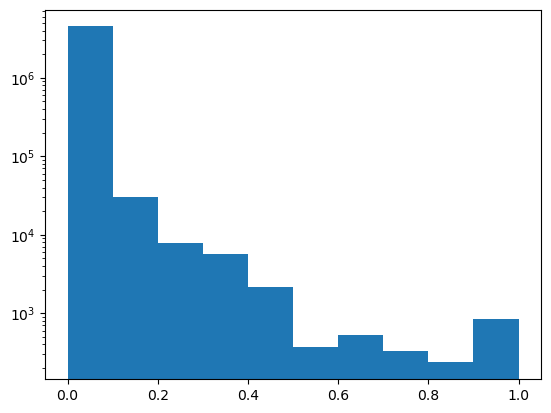

In [35]:
# histogram of connection strengths
plt.hist(inprop.data)
plt.yscale("log")
plt.show()

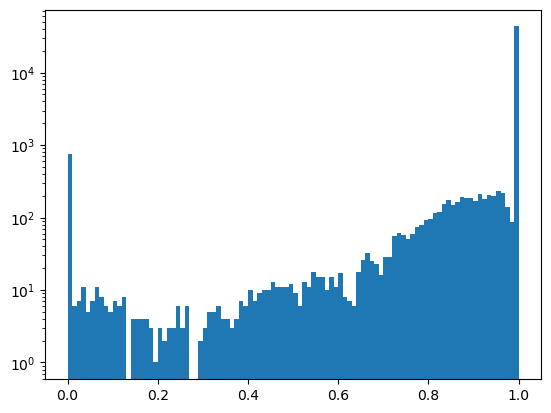

In [36]:
# histogram of column sums
colsums = inprop.sum(axis=0)
plt.hist(colsums.A1, bins=100)
plt.yscale("log")
plt.show()

In [37]:
# how many colsums are around 1?
np.sum(colsums > 0.99)

43310

In [38]:
sp.sparse.save_npz(f"../data/fafb_inprop_optic_{chosen_side}_neuron.npz", inprop)

# Some receptors have no synapses

In [39]:
# receptor neurons on the right - ids in conn
rrs = (
    set(
        optic.root_id[
            optic.combined_type.str.startswith("R") & (optic.side == chosen_side)
        ]
    )
    - nodes
)

In [40]:
len(rrs)

145

In [41]:
rrs

{720575940606503870,
 720575940607773314,
 720575940607860169,
 720575940608078345,
 720575940609016668,
 720575940609485579,
 720575940609703179,
 720575940610715204,
 720575940610821188,
 720575940611532664,
 720575940611550840,
 720575940612735194,
 720575940612839793,
 720575940612899763,
 720575940612943066,
 720575940612947635,
 720575940613196261,
 720575940613474474,
 720575940613587609,
 720575940613971683,
 720575940614792623,
 720575940614839215,
 720575940614928849,
 720575940615167742,
 720575940615708066,
 720575940615951839,
 720575940616346822,
 720575940616450626,
 720575940617920827,
 720575940618115289,
 720575940618150105,
 720575940618223419,
 720575940618437922,
 720575940618531618,
 720575940618663069,
 720575940618712221,
 720575940618718977,
 720575940618743709,
 720575940619065664,
 720575940619877022,
 720575940620232920,
 720575940620629553,
 720575940620647760,
 720575940620666315,
 720575940620722000,
 720575940620753744,
 720575940621090213,
 720575940621

In [42]:
conn_full[conn_full.pre_pt_root_id.isin(rrs)]

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg


In [43]:
conn_full[conn_full.post_pt_root_id.isin(rrs)]

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg


In [44]:
# have a look in neuroglancer
print(",".join({str(i) for i in rrs}))

720575940618718977,720575940637514414,720575940617920827,720575940633773523,720575940631750095,720575940631647173,720575940618663069,720575940623239133,720575940631048812,720575940622939998,720575940625511572,720575940627671433,720575940622303216,720575940611532664,720575940631845839,720575940622404991,720575940624141508,720575940614792623,720575940614928849,720575940615951839,720575940612735194,720575940607860169,720575940648383364,720575940620722000,720575940629854507,720575940620647760,720575940618115289,720575940626585744,720575940620753744,720575940623940963,720575940623005308,720575940622703640,720575940626928740,720575940631286636,720575940624956139,720575940608078345,720575940628131130,720575940648702084,720575940630869548,720575940629714793,720575940621944941,720575940627873299,720575940632083275,720575940609703179,720575940622270273,720575940612947635,720575940611550840,720575940615708066,720575940610821188,720575940622545023,720575940636401400,720575940621667462,720575940613

In [45]:
# just to check that the code was okay
conn_full[conn_full.pre_pt_root_id.isin(set([720575940629970489]))]

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,0.272418,0.048125,4.724386e-04,9.512688e-04
2638,720575940629970489,720575940620005542,AVLP_R,16,0.738685,0.048309,0.192288,0.017242,7.619870e-04,2.714389e-03
2800,720575940629970489,720575940626081319,AVLP_R,7,0.616549,0.119224,0.225308,0.017859,9.240883e-03,1.181937e-02
4934,720575940629970489,720575940652258806,AVLP_R,5,0.805018,0.003875,0.187979,0.001468,5.173868e-04,1.142238e-03
4985,720575940629970489,720575940624508563,AVLP_R,21,0.681668,0.033101,0.262912,0.013227,2.469837e-03,6.622759e-03
...,...,...,...,...,...,...,...,...,...,...
16753131,720575940629970489,720575940640023886,PVLP_R,5,0.605520,0.098789,0.112097,0.174059,2.384722e-03,7.150593e-03
16756383,720575940629970489,720575940612125923,PVLP_R,1,0.394534,0.002558,0.016990,0.584090,7.260212e-04,1.102308e-03
16782363,720575940629970489,720575940627710470,AVLP_R,1,0.994903,0.000038,0.005055,0.000003,5.296324e-08,5.136985e-07
16787415,720575940629970489,720575940645697668,AVLP_R,2,0.595459,0.004014,0.276213,0.124098,1.016444e-04,1.148190e-04


# save meta

In [46]:
# save to csv, one row is one neuron
meta = optic.loc[
    optic.root_id.isin(nodes),
    [
        "root_id",
        "combined_type",
        "side",
        "top_nt",
        "super_class",
        "cell_class",
        "cell_sub_class",
    ],
]
meta.loc[:, ["coords"]] = meta.root_id.map(root_to_coords)
meta.loc[:, ["idx"]] = meta.root_id.map(nodes_to_idx)
meta.loc[:, ["sign"]] = meta.top_nt.map(nt_value)
meta.rename(columns={"combined_type": "cell_type"}, inplace=True)

# adult, right hemisphere, neuron level, meta information
meta.to_csv(f"../data/fafb_optic_{chosen_side}_neuron_meta.csv")

In [47]:
meta

,root_id,cell_type,side,top_nt,super_class,cell_class,cell_sub_class,coords,idx,sign
4,720575940633370649,LC27,right,acetylcholine,visual_projection,NaN,NaN,NaN,38997,1
5,720575940638709326,LTe07,right,glutamate,visual_projection,NaN,NaN,NaN,43650,-1
6,720575940614754797,MTe12,right,acetylcholine,visual_projection,NaN,NaN,NaN,7349,1
7,720575940622660490,MTe04,right,acetylcholine,visual_projection,NaN,NaN,NaN,19520,1
8,720575940659799937,VS4,right,acetylcholine,visual_projection,NaN,NaN,NaN,48279,1
...,...,...,...,...,...,...,...,...,...,...
139248,720575940626363800,720575940626363800,right,acetylcholine,optic,ME>LO,NaN,NaN,26269,1
139250,720575940618571494,720575940618571494,right,acetylcholine,optic,ME>LO,NaN,NaN,12316,1
139251,720575940633170572,CB3823,right,acetylcholine,optic,LO,NaN,NaN,38712,1
139252,720575940650339961,CB3848,right,acetylcholine,optic,LO,NaN,NaN,47778,1


In [ ]:
# save vis_cols to csv too
vis_cols.to_csv(f"../data/Matsliah2024/fafb_{chosen_side}_vis_cols.csv")